In [1]:
pip install librosa scikit-learn python_speech_features sounddevice tqdm

In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from python_speech_features import mfcc
from tqdm import tqdm

In [3]:
import librosa
import numpy as np

# Function to extract MFCC features
def extract_mfcc_features(audio, sr=16000, num_cepstral=13, frame_length=0.02, frame_stride=0.02,
                           num_filters=32, fft_length=320, preemphasis_coeff=0.98):
    # Apply pre-emphasis
    audio = np.append(audio[0], audio[1:] - preemphasis_coeff * audio[:-1])

    # Compute the short-time Fourier transform (STFT)
    hop_length = int(frame_stride * sr)
    n_fft = fft_length
    window = "hann"  # You can choose a different window function if needed
    stft_result = librosa.core.stft(audio, hop_length=hop_length, n_fft=n_fft, window=window)

    # Compute the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(S=np.abs(stft_result)**2, sr=sr, n_mels=num_filters)

    # Logarithm of the mel spectrogram
    log_mel_energy = np.log(mel_spectrogram + 1e-9)

    # Extract MFCC features using DCT
    mfcc_features = librosa.feature.mfcc(S=log_mel_energy, n_mfcc=num_cepstral)

    # Apply mean and variance normalization across time
    mfcc_features = librosa.util.normalize(mfcc_features, norm=2, axis=0, fill=True)

    return mfcc_features


In [26]:
def preprocess_data(data_dir1):
    data = []
    labels = []
    features = []

    for class_label in os.listdir(data_dir1):
        class_path = os.path.join(data_dir1, class_label)
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
            file_path = os.path.join(class_path, file_name)
            audio, _ = librosa.load(file_path, sr=16000)

            # Simply append the raw audio data to the dataset
            data.append({
                'audio': audio,
                'label': class_label
            })

            # Extract MFCC features
            mfcc_features = extract_mfcc_features(audio)

            # Flatten the MFCC features to make them 1D
            mfcc_features_flat = mfcc_features.flatten()

            # Append the flattened features to the list
            features.append(mfcc_features_flat)
            labels.append(class_label)

    # # Ensure all features have the same length
    # max_feature_length = max(len(feature) for feature in features)
    # features = [np.pad(feature, (0, max_feature_length - len(feature))) for feature in features]

    features = np.array(features)
    labels = np.array(labels)
    classes = set(labels)

    # # Reshape the data to include the "channels" dimension
    # features = features.reshape(features.shape[0], features.shape[1], 1)
    print(features.shape())

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    return features, classes, (X_train, y_train), (X_test, y_test)

# Example usage
data_dir1 = "/content/drive/MyDrive/Wakeword"

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

def train_wakeword_model(X_train, y_train, num_classes, X_test, y_test):
    encoder = LabelEncoder()
    encoded_labels_train = encoder.fit_transform(y_train)
    encoded_labels_test = encoder.transform(y_test)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(8, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        layers.Conv1D(16, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(X_train, encoded_labels_train, epochs=35, batch_size=32, validation_data=(X_test, encoded_labels_test))

    return model, encoder


# Assuming you have features, classes, (X_train, y_train), (X_test, y_test) from preprocess_data
features, classes, (X_train, y_train), (X_test, y_test) = preprocess_data(data_dir1)
num_classes = len(classes)

# Print shapes of MFCC features and model input
print("MFCC Features Shape:", features.shape)
print("Model Input Shape:", X_train.shape[1:])

# Train the model
trained_wakeword_model, wakeword_encoder = train_wakeword_model(X_train, y_train, num_classes, X_test, y_test)
wakeword_model, wakeword_encoder = train_wakeword_model(X_train, y_train, num_classes, X_test, y_test)


Processing sheila: 100%|██████████| 1734/1734 [00:13<00:00, 130.25it/s]
<ipython-input-26-a074db56f7fd>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)


TypeError: 'tuple' object is not callable

Main Model

In [18]:
def preprocess_data(data_dir2):
    data = []
    labels = []
    features = []

    for class_label in os.listdir(data_dir2):
        class_path = os.path.join(data_dir2, class_label)
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
            file_path = os.path.join(class_path, file_name)
            audio, _ = librosa.load(file_path, sr = 16000)

            # Simply append the raw audio data to the dataset
            data.append({
                'audio': audio,
                'label': class_label
            })
            mfcc_features = extract_mfcc_features(audio)
            features.append(mfcc_features)
            labels.append(class_label)

    features = np.array(features)
    labels = np.array(labels)
    classes = set(labels)

     #Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    return features ,classes ,(X_train, y_train), (X_test, y_test)
# Example usage
data_dir2 = "/content/drive/MyDrive/hackathon"

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

def train_model(X_train, y_train, num_classes, X_test, y_test):
    encoder = LabelEncoder()
    encoded_labels_train = encoder.fit_transform(y_train)
    encoded_labels_test = encoder.transform(y_test)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Reshape((X_train.shape[1], X_train.shape[2], 1)),
        layers.Conv2D(8, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(X_train, encoded_labels_train, epochs=65, batch_size=32, validation_data=(X_test, encoded_labels_test))

    model.save('models/medical_trial_model.h5')

    return model, encoder

# Assuming you have features, classes, (X_train, y_train), (X_test, y_test) from preprocess_data
features, classes, (X_train, y_train), (X_test, y_test) = preprocess_data(data_dir2)
num_classes = len(classes)

# Print shapes of MFCC features and model input
print("MFCC Features Shape:", features.shape)
print("Model Input Shape:", X_train.shape[1:])

# Train the model
trained_model, label_encoder = train_model(X_train, y_train, num_classes, X_test, y_test)

Processing door_stop: 100%|██████████| 2823/2823 [00:20<00:00, 137.44it/s]


MFCC Features Shape: (12724, 13, 51)
Model Input Shape: (13, 51)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 13, 51, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 49, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 24, 8)          0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 5, 24, 8)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 22, 16)         1168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 11, 16)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 1s 4ms/step
Accuracy: 95.56%
Precision: 95.62%
Recall: 95.56%
F1 Score: 95.57%


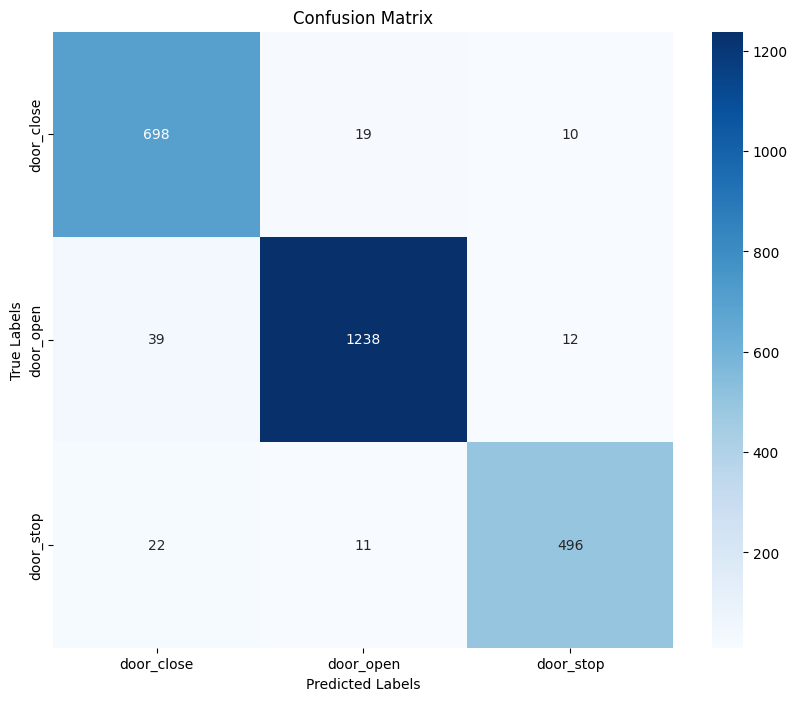

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate and print multiple evaluation metrics
def evaluate_model(model, X_test, y_test, label_encoder):
    # Predictions on test set
    y_pred = model.predict(X_test)


    # Convert predictions to class labels
    y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Calculate and print precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    f1 = f1_score(y_test, y_pred_labels, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Assuming you have the trained_model, X_test, y_test, and label_encoder
evaluate_model(trained_model, X_test, y_test, label_encoder)


In [23]:
# Example usage: Extract MFCC features for an audio file
audio_file_path = "/content/62d704b0449ba8ac5df3de46.wav"
audio, _ = librosa.load(audio_file_path, sr=16000)
mfcc_features = extract_mfcc_features(audio)

# Perform wake word detection
# Reshape the MFCC features to match the input shape expected by the wake word model
mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], mfcc_features.shape[1])

# Use the trained wake word model for wake word detection
is_wakeword_prob = trained_wakeword_model.predict(mfcc_features_reshaped)
is_wakeword = (is_wakeword_prob > 0.5).astype(int)  # Threshold for binary classification

# Inverse transform to get the label
is_wakeword_label = wakeword_encoder.inverse_transform(is_wakeword)[0]

if is_wakeword_label == 'marvin':  # Update 'marvin' to the actual wake word class label
    # If wake word is detected, perform inference with the main model
    # Your inference code for the main model goes here
    main_model_predictions = trained_model.predict_classes(mfcc_features_reshaped)
    main_model_predictions = label_encoder.inverse_transform(main_model_predictions)[0]

    print("Detected class:", main_model_predictions)
else:
    print("No wake word detected.")


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 663, 1), found shape=(None, 13, 51)
